# Raster to Polygons
Michael Dear, https://github.com/mjdear68, August 2024

**Objective**: Convert a raster classification map to polygons.

**Method**: Three methods are tested for speed and effectiveness.

## Method 1
Based on https://gis.stackexchange.com/a/439834

### Imports and data preparation

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

from sklearn.cluster import DBSCAN
import pandas as pd

from shapely.ops import unary_union

In [3]:
df = gpd.read_file('input/points.geojson')

df['xcoord'] = df.geometry.x
df['ycoord'] = df.geometry.y

### Cluster

In [4]:
#Cluster nearby points together
coords = df[['xcoord','ycoord']].values #Create a numpy array
db = DBSCAN(eps=175, min_samples=1).fit(coords) #Cluster the points. eps is max distance to cluster points together
cluster_labels = pd.Series(db.labels_).rename('cluster') #Extract cluster labels
df = pd.concat([df, cluster_labels], axis=1) #Add them to the points

In [5]:
# Unique cluster numbers
df.cluster.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20], dtype=int64)

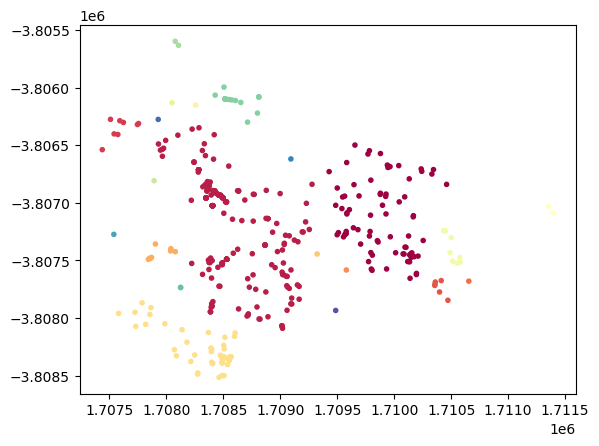

In [6]:
#Adjust eps and plot until it looks as good as possible
fig, ax = plt.subplots()
ax.scatter(x=df['xcoord'], y=df['ycoord'], c=df['cluster'], marker='.', cmap='Spectral')

### Create convex hulls

In [7]:
#Create convex hulls from each cluster
hulls = [] #A list to hold clusterids and convex hull geometries
for clusterid, frame in df.loc[df['cluster']!=-1].groupby('cluster'): #For each cluster group except -1
    geom = unary_union(frame.geometry.tolist()).convex_hull #Create one multipoint and convex hull it
    hulls.append([clusterid, geom])
    
df2 = pd.DataFrame.from_records(data=hulls, columns=['cluster','geometry'])
gdf = gpd.GeoDataFrame(data=df2, geometry=df2['geometry'], crs=df.crs)


In [8]:
gdf

,cluster,geometry
0,0,"POLYGON ((1710139.394 -3807655.694, 1709806.14..."
1,1,"POLYGON ((1709020.305 -3808089.940, 1708388.08..."
2,2,"POLYGON ((1707438.636 -3806539.101, 1707510.75..."
3,3,"POLYGON ((1710471.532 -3807846.508, 1710398.29..."
4,4,POINT (1710655.031 -3807680.708)
5,5,POINT (1709580.396 -3807583.757)
6,6,"POLYGON ((1707843.452 -3807491.197, 1707904.83..."
7,7,POINT (1709324.401 -3807444.728)
8,8,"POLYGON ((1708463.718 -3808515.493, 1708275.15..."
9,9,POINT (1708257.658 -3806151.968)


<Axes: >

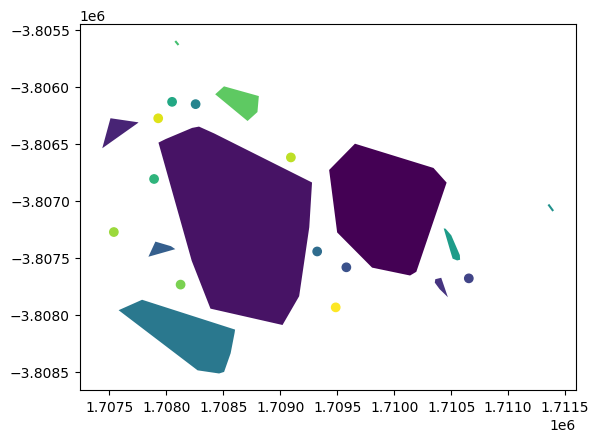

In [9]:
gdf.plot(column='cluster')

### Combine into multipolygon

In [10]:
# Combine polygons into a single mulipolygon
# https://stackoverflow.com/a/74991509/8299958
# https://gis.stackexchange.com/a/413810
gdf2 = gdf.loc[gdf.geometry.geom_type=='Polygon'].dissolve()
gdf2

,geometry,cluster
0,"MULTIPOLYGON (((1707788.104 -3807868.576, 1708...",0


<Axes: >

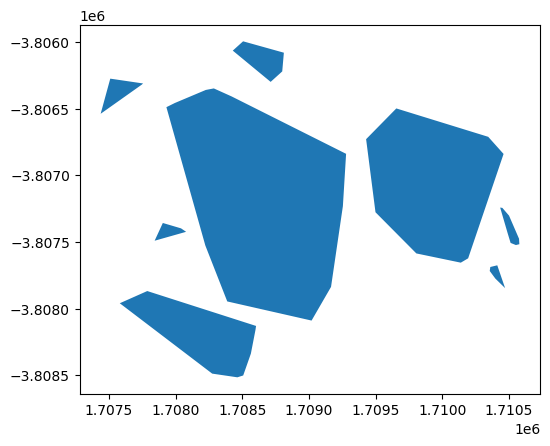

In [11]:
gdf2.plot()

### Save to file

In [12]:
# Save to file
gdf2.to_file('output/method_1_polygons_from_points.geojson', driver='GeoJSON')

## Method 2
Repeat the following for each class in the dataset.
1. Create GoeDataFrame of points
2. Buffer the points
3. Get the bounds of the buffered points
4. Convert the bounds of a point to a polygon
5. Merge all touching "buffer polygons" into individual polygons

References
* https://stackoverflow.com/a/72310089/8299958
* https://stackoverflow.com/a/68762419/8299958

### Imports

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import rioxarray
import numpy as np

from shapely.geometry import Polygon
from shapely.ops import unary_union

### Proof of concept

In [97]:
df = pd.DataFrame({'x': [0,1,3], 'y': [1,1,1]})

In [98]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['x'], df['y']))

<Axes: >

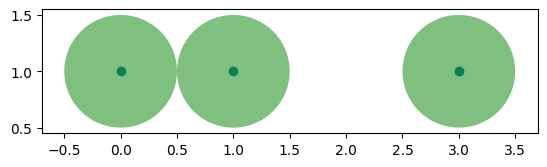

In [99]:
fig, ax = plt.subplots()
gdf.plot(ax=ax)
gdf.buffer(0.5).plot(ax=ax, color='green', alpha=0.5)

[(-0.5, 0.5), (0.5, 0.5), (0.5, 1.5), (-0.5, 1.5)]
[(0.5, 0.5), (1.5, 0.5), (1.5, 1.5), (0.5, 1.5)]
[(2.5, 0.5), (3.5, 0.5), (3.5, 1.5), (2.5, 1.5)]


<Axes: >

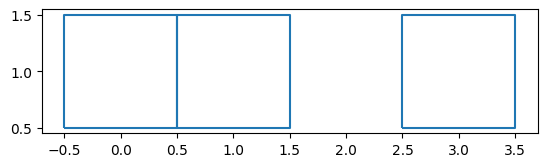

In [108]:
# https://stackoverflow.com/a/72310089/8299958

polygons = []

for row in gdf.index:
    # Get the X, Y coordinates of the point buffer bounds
    X1, Y1, X2, Y2 = gdf.iloc[[row]].buffer(0.5).total_bounds
    
    # Create the polygon; anti-clockwise from bottom-left
    polygon = [(X1, Y1), (X2, Y1), (X2, Y2), (X1, Y2)]
    print(polygon)
    polygons.append(Polygon(polygon))

gdf_poly = gpd.GeoDataFrame(geometry=polygons)

gdf_poly.boundary.plot()

<Axes: >

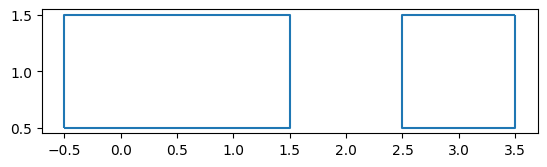

In [105]:
# Dissolve to create multipolygon with touching geometries merged
gdf_dissolved = gdf_poly.dissolve()
gdf_dissolved.boundary.plot()

In [106]:
gdf_dissolved.area

0    3.0
dtype: float64

### Import and prepare the test data

In [16]:
# Load the test data
da = rioxarray.open_rasterio('input/test.tiff', default_name='class')
da

<xarray.DataArray 'class' (band: 1, y: 100, x: 100)>
[10000 values with dtype=uint8]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 1.821e+06 1.821e+06 ... 1.824e+06 1.824e+06
  * y            (y) float64 -3.723e+06 -3.723e+06 ... -3.726e+06 -3.726e+06
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      SVM_Class_linear

In [19]:
df = da.to_dataframe().reset_index()
df.head()

,band,y,x,spatial_ref,class
0,1,-3722685.0,1821465.0,0,5
1,1,-3722685.0,1821495.0,0,4
2,1,-3722685.0,1821525.0,0,4
3,1,-3722685.0,1821555.0,0,5
4,1,-3722685.0,1821585.0,0,5


In [22]:
df.x

0       1821465.0
1       1821495.0
2       1821525.0
3       1821555.0
4       1821585.0
          ...    
9995    1824315.0
9996    1824345.0
9997    1824375.0
9998    1824405.0
9999    1824435.0
Name: x, Length: 10000, dtype: float64

In [25]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x, df.y))
gdf.head()

,band,y,x,spatial_ref,class,geometry
0,1,-3722685.0,1821465.0,0,5,POINT (1821465.000 -3722685.000)
1,1,-3722685.0,1821495.0,0,4,POINT (1821495.000 -3722685.000)
2,1,-3722685.0,1821525.0,0,4,POINT (1821525.000 -3722685.000)
3,1,-3722685.0,1821555.0,0,5,POINT (1821555.000 -3722685.000)
4,1,-3722685.0,1821585.0,0,5,POINT (1821585.000 -3722685.000)


In [26]:
np.sort(gdf['class'].unique())

array([1, 2, 3, 4, 5, 6], dtype=uint8)

### Apply the method to the test data

In [27]:
%%time

class_gdfs = []
classes = np.sort(gdf['class'].unique())

for cl in classes:
    # Intialise the list for the pixel polygons
    pixel_polygons = []
    for row in gdf[gdf['class']==cl].index:
        # Get the X, Y coordinates of the point buffer bounds
        X1, Y1, X2, Y2 = gdf.iloc[[row]].buffer(15).total_bounds
        
        # Create the polygon; anti-clockwise from bottom-left
        polygon = [(X1, Y1), (X2, Y1), (X2, Y2), (X1, Y2)]
        
        # Append pixel polygon to output list
        pixel_polygons.append(Polygon(polygon))
    
    # Convert pixel_polygons to gdf and append to class_gdfs
    # For unary_union() see https://stackoverflow.com/a/40386377/8299958
    class_gdfs.append(gpd.GeoSeries(unary_union(pixel_polygons)))
   
# Create the final GeoDataFrame
gdf_poly = gpd.GeoDataFrame(geometry=pd.concat(class_gdfs))

# Include a classes column
gdf_poly['class']=classes

# Set the crs to the data array crs
gdf_poly = gdf_poly.set_crs(da.rio.crs)

CPU times: total: 6.16 s
Wall time: 7.37 s


### Check the results

In [28]:
gdf_poly

,geometry,class
0,"MULTIPOLYGON (((1822170.000 -3725640.000, 1822...",1
0,"MULTIPOLYGON (((1821600.000 -3725670.000, 1821...",2
0,"MULTIPOLYGON (((1821450.000 -3725250.000, 1821...",3
0,"MULTIPOLYGON (((1821510.000 -3725160.000, 1821...",4
0,"MULTIPOLYGON (((1821480.000 -3725220.000, 1821...",5
0,"MULTIPOLYGON (((1821960.000 -3725610.000, 1821...",6


<Axes: >

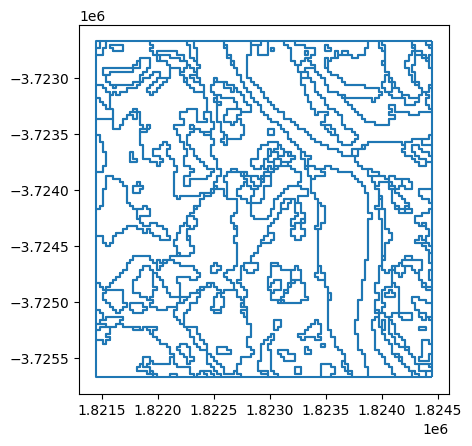

In [29]:
gdf_poly.boundary.plot()

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

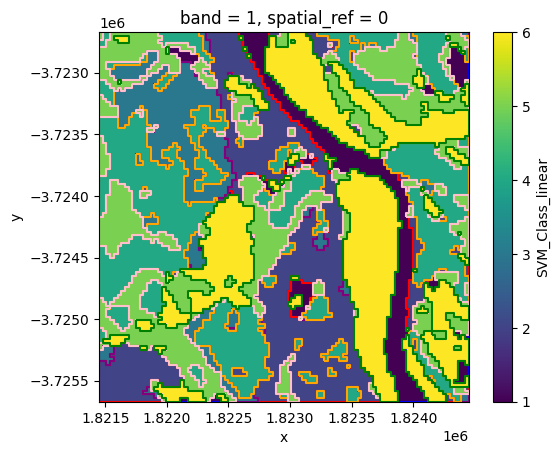

In [30]:
fig, ax = plt.subplots()
da.plot(ax=ax)
gdf_poly.boundary.plot(ax=ax, color=['blue','red','purple','orange','pink','green'], alpha=1)

### Write to file

In [32]:
gdf_poly.to_file('output/method_2_polygons.geojson', driver='GeoJSON')

In [276]:
gdf_poly.crs